# Project 3: Natural Language Processing of Subreddit Posts

### Contents:

- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
    - [WordCloud](#WordCloud)
    - [Word Count](#Word-Count)
    - [Ngram Visualization](#Ngram-Visualization)
    - [Additional Stopwords](#Additional-Stopwords)

### Import Libraries

In [1]:
# Import standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

# Import time- and API- related libraries
import time, requests
from datetime import datetime
import json

# Import warnings to remove flags when project is complete
import warnings
warnings.filterwarnings('ignore')

#import pre-processing libraries for cleaning the data
import string
import re
import nltk
from nltk.tokenize import RegexpTokenizer, sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Import modelling-related libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


pd.set_option('display.max_colwidth', 100)

## Exploratory Data Analysis

### WordCloud

A Wordcloud is a visual representations of words that give greater prominence to words that appear more frequently. A wordcloud is generated to observe the 200 most frquently obsereved words for each subreddit, and allows us to identify any additional stopwords that needs to be added to the existing list of stopwords.

In [2]:
# Import image to np.array
mask_investing = np.array(Image.open('../project_3/images/moneybag.png'))

In [3]:
# read the dataset
combined_df2 = pd.read_csv('../project_3/data/combined_df2.csv')

In [4]:
#text must be a string for wordcloud
text_invest = ' '.join(i for i in combined_df2.loc[combined_df2['subreddit'] == 1, 'all_text'])

In [5]:
#text must be a string for wordcloud
text_crypto = ' '.join(i for i in combined_df2.loc[combined_df2['subreddit'] == 0, 'all_text'])

In [6]:
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud, interpolation='bilinear') 
    # No axis details
    plt.axis("off");

In [7]:
#list of stopwords

stopword = nltk.corpus.stopwords.words('english')

additional_stopwords = ['like', 'blah', 'poll',
                       'get', 'thank', 'thankyou',
                       'you', 'word', 'does',
                       'anyone', 'know', 'blah', 
                       'hear', 'words']

all_stopwords = stopwords.words('english')
all_stopwords.extend(additional_stopwords)

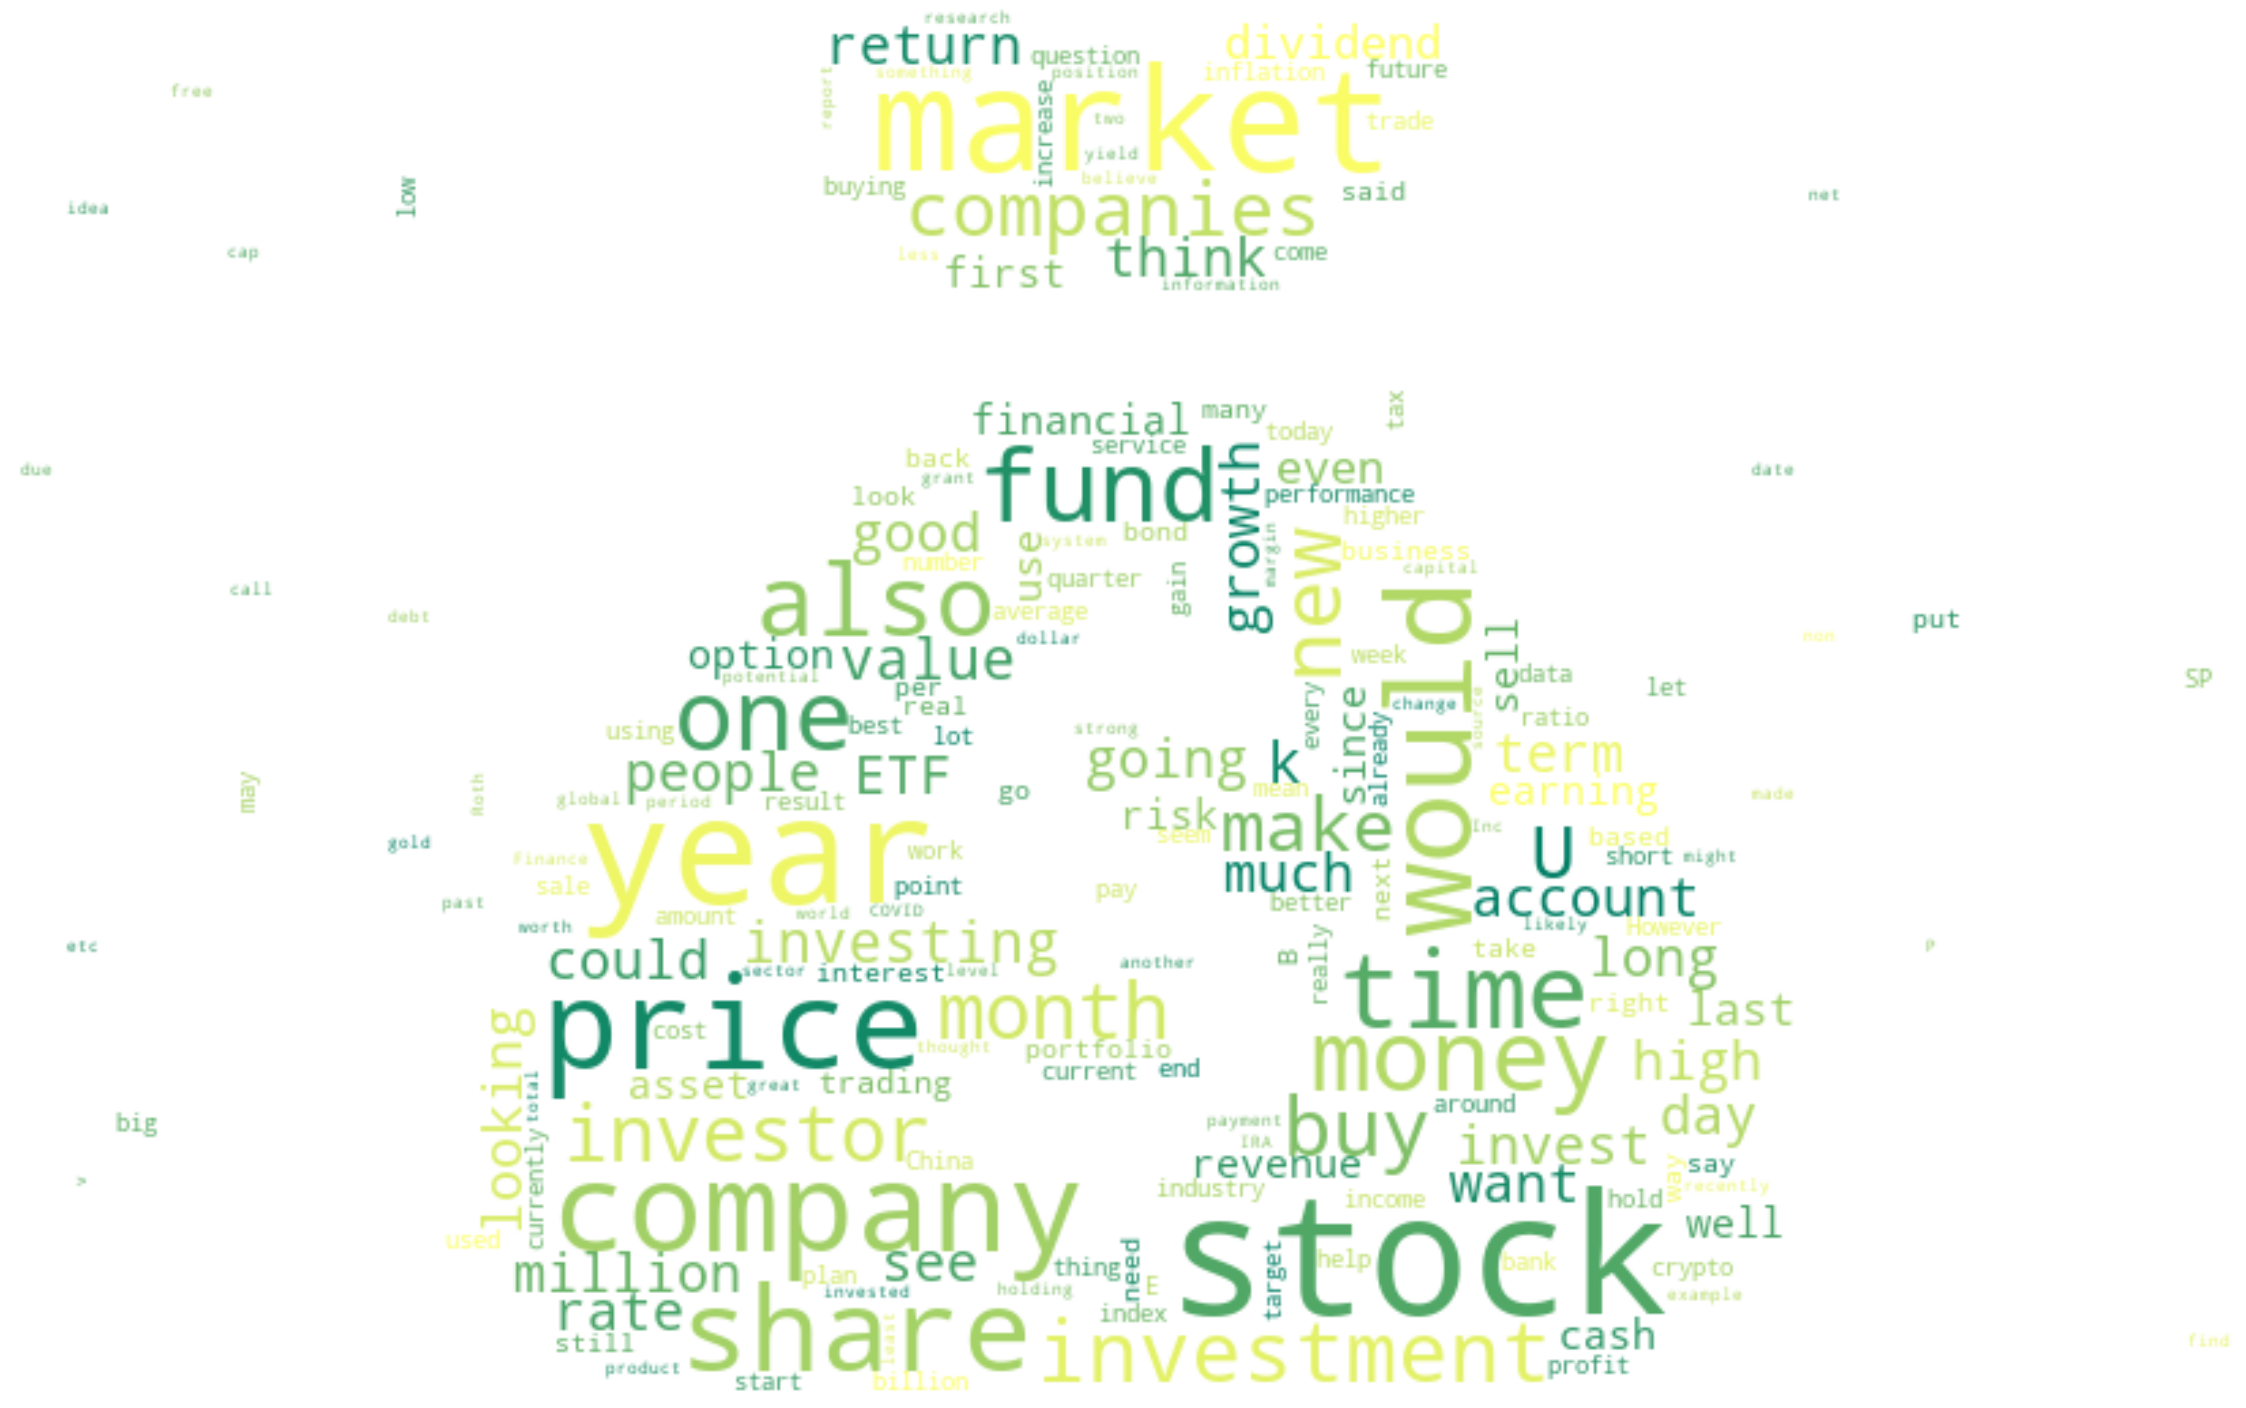

In [8]:
# Generate word cloud for investing subreddit
#Set collocations to False to ensure that the word cloud doesn’t appear as if it contains any duplicate words
wordcloud_investing = WordCloud(width= 500,
                                height = 200,
                                random_state=50,
                                background_color='white',
                                colormap='summer',
                                collocations=False, 
                                max_words = 200,
                                stopwords = all_stopwords,
                                mask = mask_investing).generate(text_invest)

#plot
# Set figure size
plt.figure(figsize=(40, 30))
# Display image
plt.imshow(wordcloud_investing, interpolation='bilinear') 
# No axis details
plt.axis("off");

**Observations for r/investing subreddit only**

We observe that words with large relative sizes are: 'year', 'price', 'coin', 'market', 'money', and 'time' to name a few, for the r/investing subreddit. Additionally, filler words like 'could' and 'would' are observed as well. 

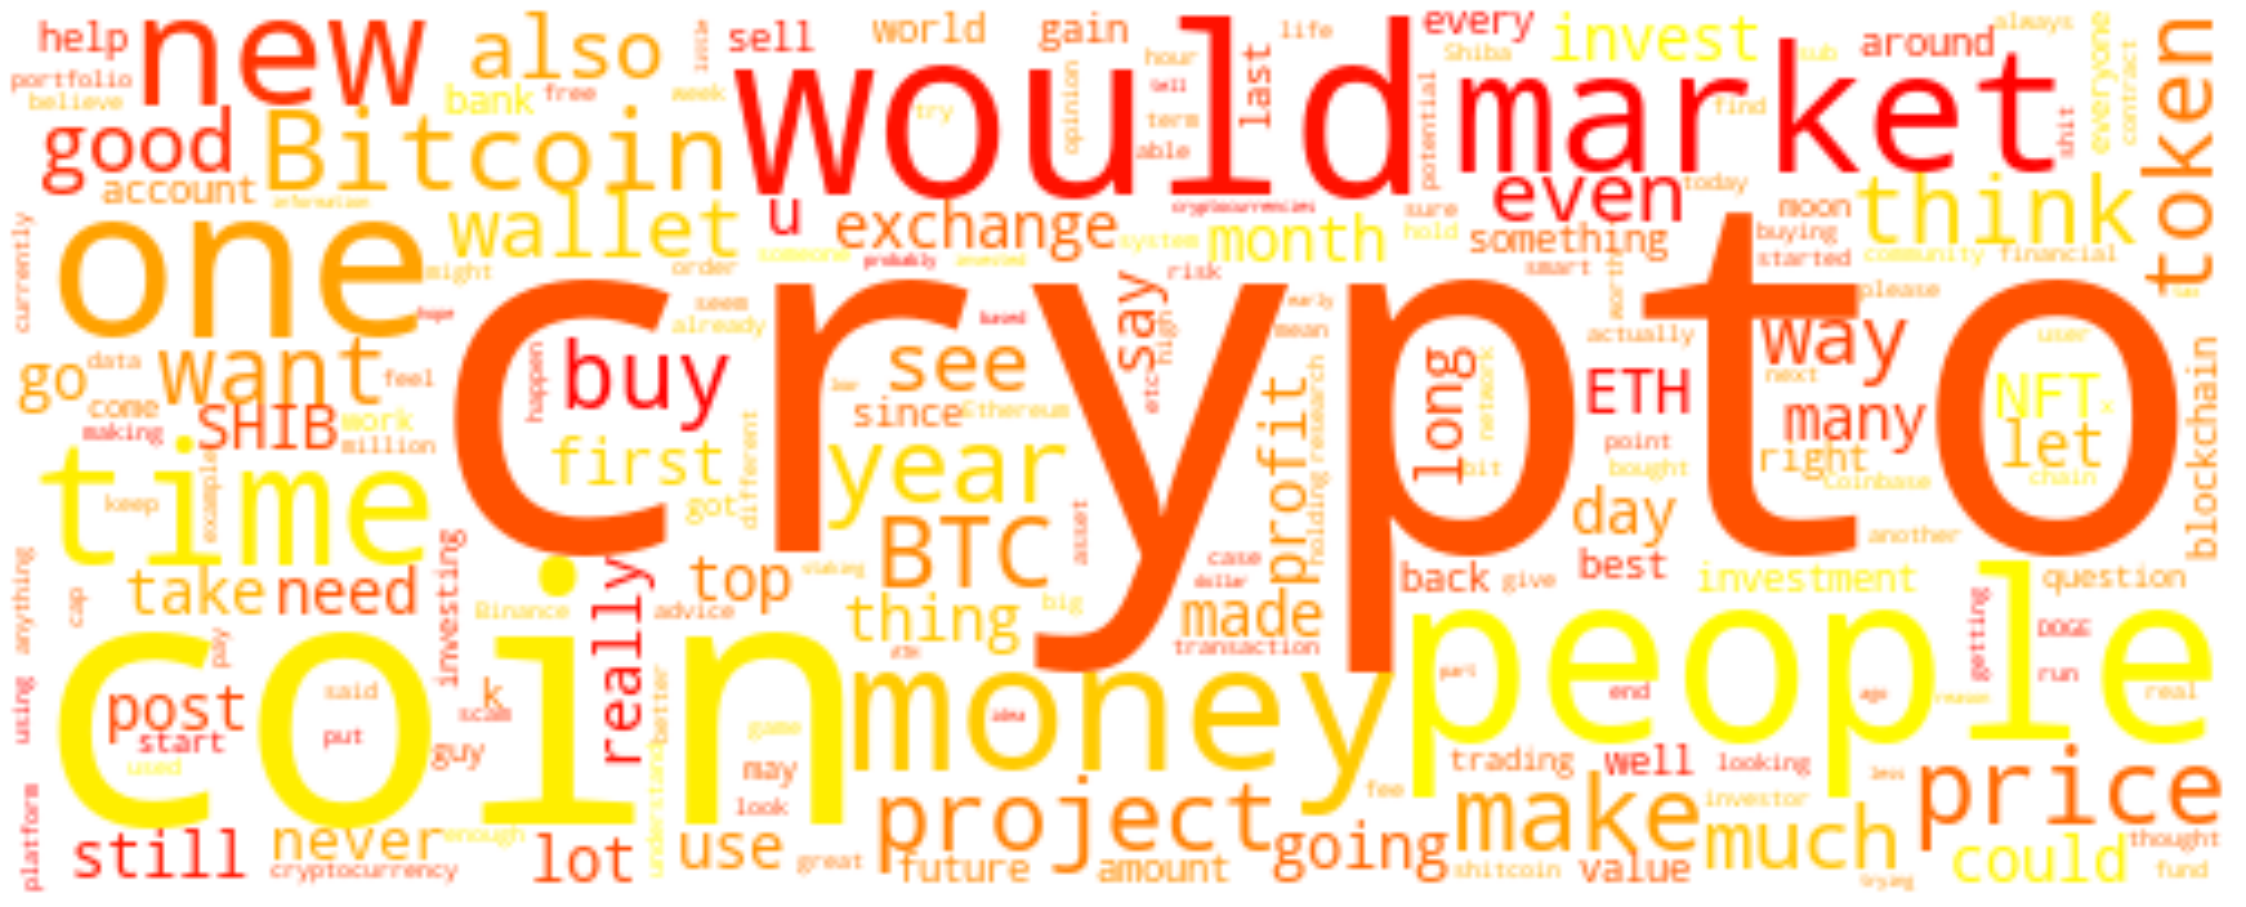

In [9]:
# Generate word cloud for crypto subreddit
#Set collocations to False to ensure that the word cloud doesn’t appear as if it contains any duplicate words
wordcloud_crypto = WordCloud(width= 500,
                             height = 200,
                             random_state=50,
                             background_color='white',
                             colormap='autumn',
                             collocations=False, 
                             max_words = 200,
                             stopwords = all_stopwords,
                             ).generate(text_crypto)

#plot
# Set figure size
plt.figure(figsize=(40, 30))
# Display image
plt.imshow(wordcloud_crypto, interpolation='bilinear') 
# No axis details
plt.axis("off");

**Observations for r/CryptoCurrency subreddit only**

We observe that words with large relative sizes are: 'crypto', 'stock', 'coin', 'people', 'money', and 'share' to name a few, for the r/investing subreddit. Additionally, filler words like 'could' and 'would' are observed as well. 

**Observations for both wordclouds for both subreddits**

1. We observe that several words found with large relative size to be present in both word clouds. For example, 'crypto', 'year', 'coin' and 'time'. This seems to indicate that time is an important factor for both traditional investing and in cryptocurrency.

2. Additionally, crypotcurrency appears to be a frequent discussion in the r/investing subreddit as well.

3. However, we also note the differences in the two word clouds. However, they both have slightly differing focus words. The r/investing subreddit has focus words like 'etf' and 'trade', while the r/CryptoCurrency subreddit has focus words such as 'btc' and 'token', which are not present in the other subreddit. This is a good indicator, as it shows that they subreddits might have some diverging discussions based. 

3. We, however, observe & acknowledge that the focus words for both subreddits appear to be rather similar as a whole. Hence, we would need to include additional stopwords to be able to see if there is the focus words differ for both subreddits. The more differeing focus words each subreddit has, the higher the probability that a good predictive model would be able to be produced.

### Word Count

A plot is created to show the word count distribution of the collected subreddit posts. The r/investing subreddit is indicated as '1' while, the r/CryptoCurrency subreddit is indicated as '0'.

In [10]:
#word count

# Step 1: Create and apply function for word count:

def make_word_count(row):
    row['word_count'] = len(row['all_text'])
    return row

combined_df2 = combined_df2.apply(make_word_count, axis=1)

<Figure size 432x3600 with 0 Axes>

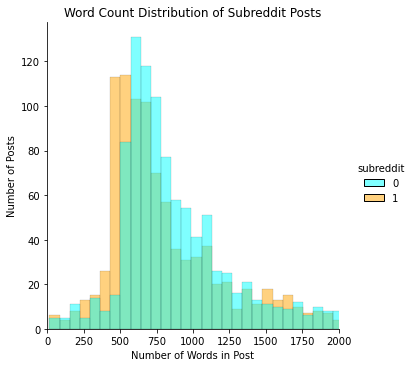

In [11]:
# Step 2: Word count visualization

plt.figure(figsize=(6,50))

sns.displot(data=combined_df2, x="word_count", hue="subreddit", palette=['cyan', 'orange'], bins=250, kind="hist")

plt.xlim(0, 2_000)
plt.title('Word Count Distribution of Subreddit Posts')
plt.ylabel('Number of Posts')
plt.xlabel('Number of Words in Post');

**Observations**

1. The distribution of word count is unimodal with a peak around the 600 word range in both subreddits.
2. The high peak in the both subreddit is shown by the drastic increase in frequency around the 400-500 word range, as compared to the bin after
3. The distribution is skewed right, with a long tail. This suggests that while most posts are concise in nature, outlier posts with more word counts are also present.

### Ngram Visualization

Below are the steps that are taken for the initial step of visualization:
1. Creation of separate series' for each subreddit so that we can display the most frequent unigram, bigram and trigram for each subreddit and compare the results.
2. Create function for Count Vectorizer Visualization
3. Create function for TF-IDF Vectorizer Visualization

After the ngrams are visualized, for both vectorizzers, additional stopwords are added to the existing list of stopwords so that we are able to eliminate words that are so commonly used that they carry very little useful information. Then, the ngrams are populated again for each subreddit and each vectorizer.

In [12]:
# Step 1: Create separate series for each subreddit
visual_investing = combined_df2.loc[combined_df2['subreddit'] == 1, 'all_text']
visual_crypto = combined_df2.loc[combined_df2['subreddit'] == 0, 'all_text']

In [17]:
combined_df2

,subreddit,all_text,word_count
0,1,"['A Great Short Setup on NYSE', ' Snapshot Double top on ATH level Bullish RSI divergence']",91
1,1,"['A Great Short Setup on NYSE', ' Double top on ATH level Bullish RSI divergence']",82
2,1,"['Inherited large amount of equity Not sure whether to liquidate and invest now or wait', 'I m y...",1141
3,1,"['Daily General Discussion and spitballin thread October ', 'Have a general question Want to off...",813
4,1,"['Daily Advice Thread All basic help or advice questions must be posted here October ', 'If your...",1109
...,...,...,...
2094,0,"['What crypto you own perform the best right now ', 'Hello hello traders stakers and moon farmer...",580
2095,0,"['Know There Is A Moon Faucet ', 'Hi guys Just a reminder for people who doesn t know that there...",624
2096,0,['Why old dictators fear cryptocurrency Thai junta is warning young investors to beware of the r...,570
2097,0,['Many of us in this subreddit are extremely new to crypto currency What are some important rule...,746


In [13]:
visual_investing

0               ['A Great Short Setup on NYSE', ' Snapshot Double top on ATH level Bullish RSI divergence']
1                        ['A Great Short Setup on NYSE', ' Double top on ATH level Bullish RSI divergence']
2       ['Inherited large amount of equity Not sure whether to liquidate and invest now or wait', 'I m y...
3       ['Daily General Discussion and spitballin thread October ', 'Have a general question Want to off...
4       ['Daily Advice Thread All basic help or advice questions must be posted here October ', 'If your...
                                                       ...                                                 
1045    ['U S Opens Formal Probe Into Tesla Autopilot System', 'Bloomberg just reported that Tesla s aut...
1046    ['USD HKD sell trade went wrong ', 'I wanted to get some stocks on the hongkong stock exchange a...
1047    ['Should I invest in airplane companies ', 'I was talking to a friend about investing in somethi...
1048    ['Has anyone heard o

In [14]:
# Step 2: Create function for CVEC Vectorizer Visualization
def cvec_ngram(range_value):

    # Instantiate Vectorizer
    cvec_visual = CountVectorizer(ngram_range=(range_value, range_value), stop_words =all_stopwords)
    
    #create word vector on investing subreddit
    investing_clean_visual = cvec_visual.fit_transform(visual_investing)
    investing_clean_visual_df = pd.DataFrame(investing_clean_visual.todense(),
                                             columns = cvec_visual.get_feature_names())
    
    crypto_clean_visual = cvec_visual.fit_transform(visual_crypto)
    crypto_clean_visual_df = pd.DataFrame(crypto_clean_visual.todense(),
                                          columns = cvec_visual.get_feature_names())
    
    # Plotting bar graph
    plt.figure(figsize=(9, 4))
    
    plt.subplot(1, 2, 1)
    investing_clean_visual_df.sum().sort_values(
        ascending=False).head(20).plot(kind='barh');
    plt.title('Top 20 Word(s) in r/investing (CVEC)')
    plt.ylabel('Word(s)')
    plt.xlabel('Frequency (CVEC)')

    plt.subplot(1, 2, 2)
    crypto_clean_visual_df.sum().sort_values(
        ascending=False).head(20).plot(kind='barh');
    plt.title('Top 20 Word(s) in r/CryptoCurrency (CVEC)')
    plt.ylabel('Word(s)')
    plt.xlabel('Frequency (CVEC)')
    
    plt.tight_layout()

In [15]:
# Step 3: Create function for TFIDF Vectorizer Visualization

def tvec_ngram(range_value):

    # Instantiate Vectorizer
    tvec_visual = TfidfVectorizer(ngram_range=(range_value, range_value), stop_words =all_stopwords)
    
    #counts for the vectors
    investing_clean_visual = tvec_visual.fit_transform(visual_investing)
    investing_clean_visual_df = pd.DataFrame(investing_clean_visual.todense(),
                                             columns = tvec_visual.get_feature_names())
    
    crypto_clean_visual = tvec_visual.fit_transform(visual_crypto)
    crypto_clean_visual_df = pd.DataFrame(crypto_clean_visual.todense(),
                                          columns = tvec_visual.get_feature_names())
    
    # Plotting bar graph
    plt.figure(figsize=(9, 4))
    
    plt.subplot(1, 2, 1)
    investing_clean_visual_df.sum().sort_values(
        ascending=False).head(20).plot(kind='barh');
    plt.title('Top 20 Word(s) in r/investing (TVEC)')
    plt.ylabel('Word(s)')
    plt.xlabel('Frequency (TVEC)')

    plt.subplot(1, 2, 2)
    crypto_clean_visual_df.sum().sort_values(
        ascending=False).head(20).plot(kind='barh');
    plt.title('Top 20 Word(s) in r/CryptoCurrency (TVEC)')
    plt.ylabel('Word(s)')
    plt.xlabel('Frequency (TVEC)')
    
    plt.tight_layout()

**Unigram Observations**

There are common overlapping words for both subreddits. For example, 'buy', 'price' and 'market'. This makes sense as both subredditss involves money.  

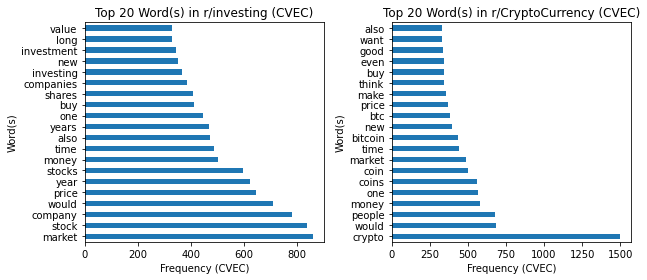

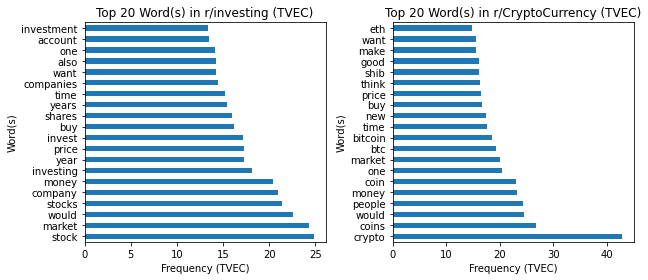

In [16]:
cvec_ngram(1)
tvec_ngram(1)

**Bigram Observations**

However, for the bigram, we notice an increasing divergence in the words. This words allow us to clearly classify which subredddit the post belongs to. For example, 'index funds' is a form of traditional security, while 'shiba inu' is a crypto coin.

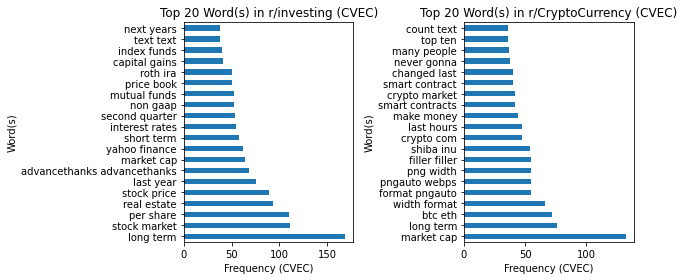

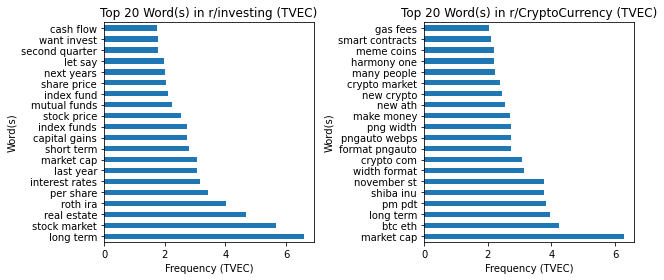

In [16]:
cvec_ngram(2)
tvec_ngram(2)

**Trigram Observations**

For the trigram, there are some words with meanings like 'dividends per share' and 'yahoo finance recommendation'. However, we also notice the presence of words that are nrelated to our subreddits such as 'png width format' and 'advancethanks advancethanks advancethanks'.

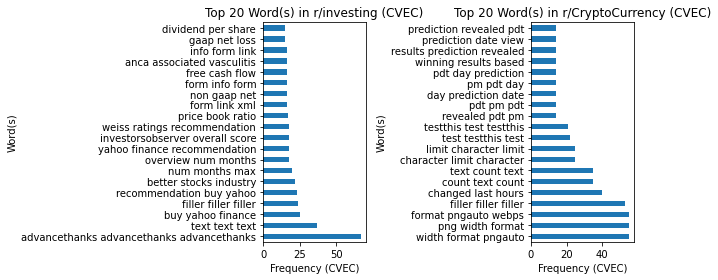

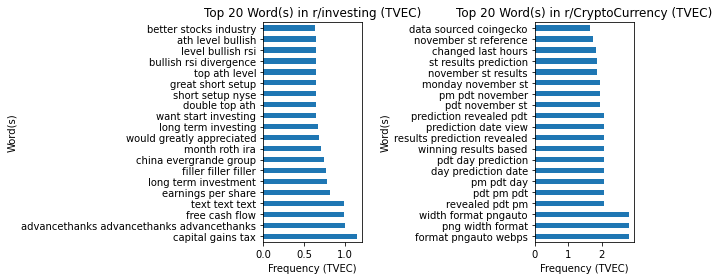

In [17]:
cvec_ngram(3)
tvec_ngram(3)

### Additional Stopwords

Hence, we will increase our list of stopwords to remove words that are unrelated in helping us identify hot trends & new leads for traditional securities and CryptoCurrency in both subreddits.

In [18]:
#second round of additional stopwords

additional_stopwords_2 = ['shitpost', 'filler', 'filer', 
                          'characters', 'character', 'png',
                          'width', 'format', 'like',
                          'pngauto', 'form', 'info',
                          'limittext', 'limit', 'text', 
                          'wa', 'ha', 'please',
                          'let', 'would', 'love', 
                          'make', 'sense', 'doe',
                          'need', 'put', 'could',
                          'want', 'would', 'year',
                          'years', 'shit', 'going', 
                         'much', 'even', 'though', 
                         'last', 'hours', 'hour', 
                         'webps', 'jpg', 'let',
                         'lets', 'see', 'happen'
                         'also']

all_stopwords += additional_stopwords_2

The cvec & tvec is ran again with the additional stopwords.

**Unigram**

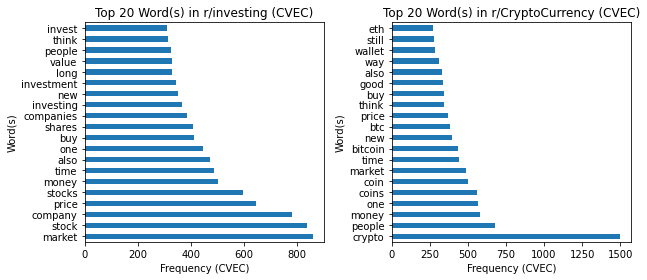

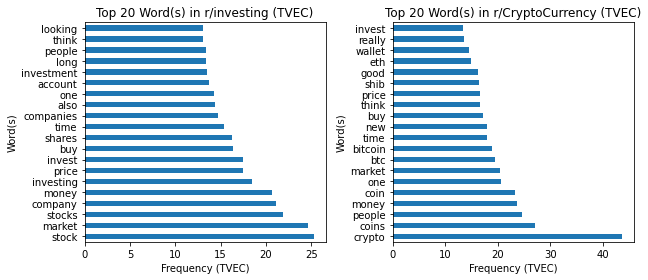

In [19]:
cvec_ngram(1)
tvec_ngram(1)

**Bigram**

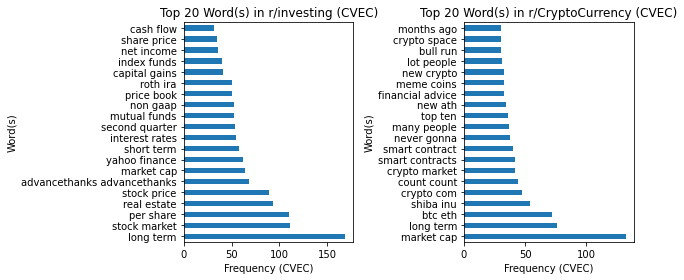

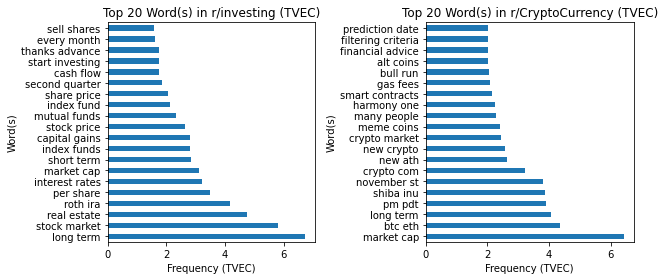

In [20]:
cvec_ngram(2)
tvec_ngram(2)

**Trigram**

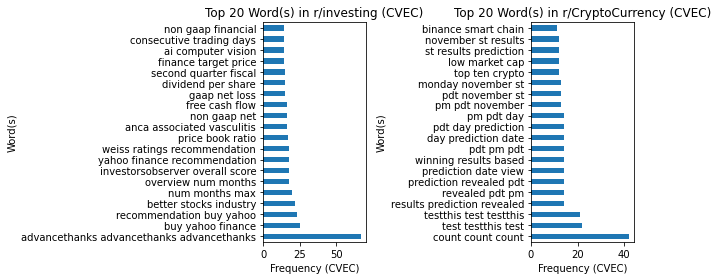

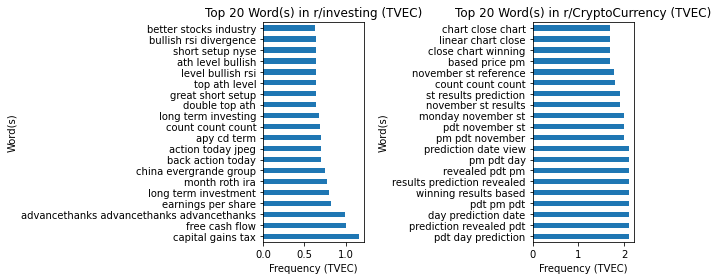

In [21]:
cvec_ngram(3)
tvec_ngram(3)

**Observations**

After running the vectorizers against the additional stopwords, we are able to observe more organice trends and keywords such as 'roth ira' and 'binance smart chain' where shows where the latest interest in the subreddits lies in. 

Referenced URL:
https://www.investopedia.com/terms/r/rothira.asp